In [1]:
# import all needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

# read csv data
data = pd.read_csv("time_series_covid19_confirmed_global.csv", index_col=0)

# extract the starting date up to the last date
x = list(data.columns)
x = x[3:]

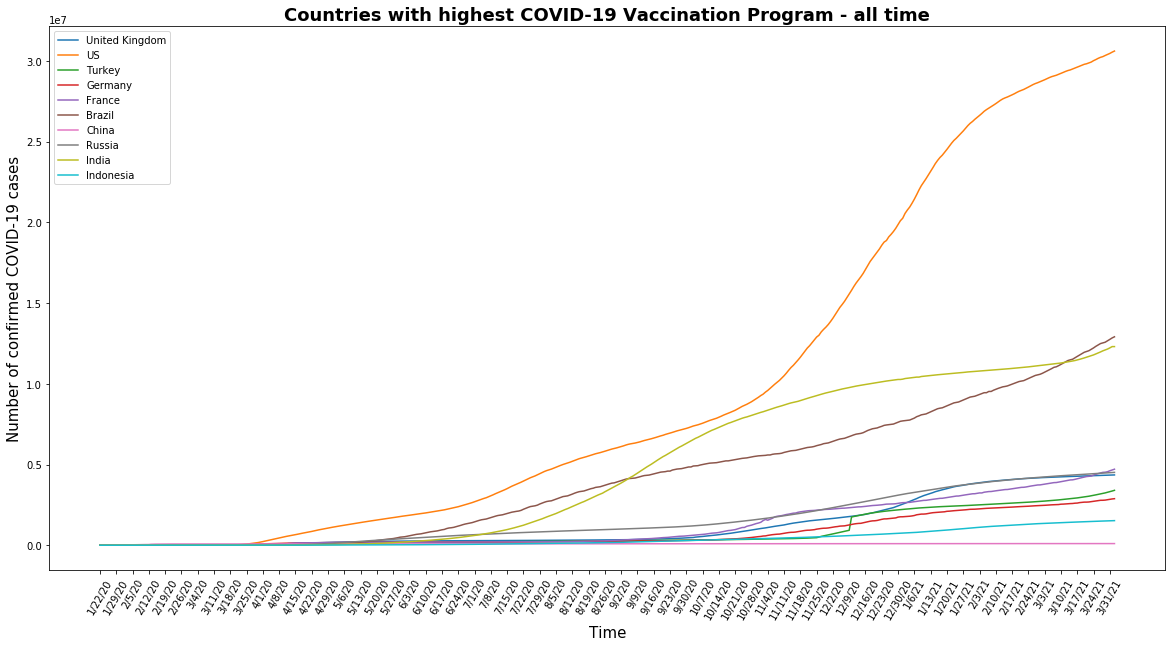

In [2]:
# <<INPUT>> considered countries' name - Top Ten countries with highest number of vaccination program ratio
countries = ['United Kingdom', 'US', 'Turkey', 'Germany', 'France', 
             'Brazil', 'China', 'Russia', 'India', 'Indonesia']

# plot the ten considered countries
fig = plt.figure(figsize=(20,10)) 
ax = fig.add_subplot(111)
for i in range(len(countries)):
    res = data[data['Country/Region'] == countries[i]]
    # since there are many regions in China, they should be summed together first
    if (countries[i] == 'China'):
        y = res.sum(axis=0)
        y = y[3:]
    else:
        y = res.iloc[-1,3:]
    ax.plot(x, y, label=countries[i])

ind = [i for i in range(0, len(x), 7)]
date = [x[i] for i in ind]
plt.xticks(ind, date, rotation=60)

# title, label, and legend
ax.set_title("Countries with highest COVID-19 Vaccination Program - all time", fontsize=18, fontweight='bold')
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Number of confirmed COVID-19 cases', fontsize=15)
ax.legend()

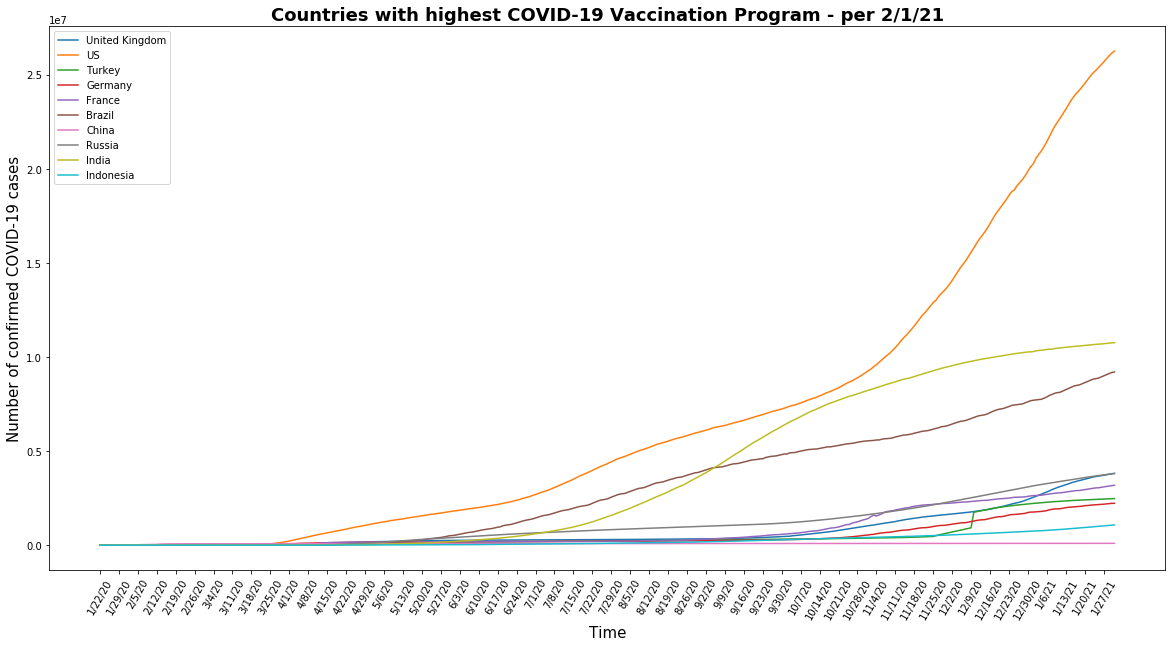

In [3]:
# <<INPUT>> the considered START DATE for mass vaccination program
endDate = '2/1/21'

# plot the ten considered countries
fig = plt.figure(figsize=(20,10)) 
ax = fig.add_subplot(111)
for i in range(len(countries)):
    ed = x.index(endDate)
    res = data[data['Country/Region'] == countries[i]]
    # since there are many regions in China, they should be summed together first
    if (countries[i] == 'China'):
        y = res.sum(axis=0)
        y = y[3:(ed+3)]
    else:
        y = res.iloc[-1,3:(ed+3)]
    ax.plot(x[:ed], y, label=countries[i])

ind = [i for i in range(0, len(x[:ed]), 7)]
date = [x[i] for i in ind]
plt.xticks(ind, date, rotation=60)

# title, label, and legend
ax.set_title("Countries with highest COVID-19 Vaccination Program - per " + endDate, fontsize=18, fontweight='bold')
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Number of confirmed COVID-19 cases', fontsize=15)
ax.legend()

In [4]:
### RUN FROM HERE for each LSTM model built
# <<INPUT>> country name and endDate (before the mass vaccination program started)
country = 'Indonesia'
endDate = '2/1/21'

ed = x.index(endDate)
res = data[data['Country/Region'] == country]
# since there are many regions in China, they should be summed together first
if (country == 'China'):
    y = res.sum(axis=0)
    i = 3
    while y[i] == 0:
        i +=1
    # processed data all time (including after mass vaccination program)
    procDataA = y[i:]
    # processed data from start to endDate (before mass vaccination program)
    procDataB = y[i:(ed+3)]
else:
    i = 3
    while res.iloc[-1,i] == 0:
        i +=1
    procDataA = res.iloc[-1,i:]
    procDataB = res.iloc[-1,i:(ed+3)]

print('ALL Time data length: %d' % len(procDataA))
print('Before Vaccination data length: {}'.format(len(procDataB)))

ALL Time data length: 397
Before Vaccination data length: 336


In [5]:
# <<INPUT>> test size [0 - 1]
testSize = 0.2

# All Time
trainA = procDataA[0:-math.floor(testSize*len(procDataA)+1)]
testA = procDataA[-math.ceil(testSize*len(procDataA)):]
print(len(trainA), len(testA))

# Before Vaccination Program
trainB = procDataB[0:-math.floor(testSize*len(procDataB)+1)]
testB = procDataB[-math.ceil(testSize*len(procDataB)):]
print(len(trainB), len(testB))

317 80
268 68


In [6]:
# <<INPUT>> look_back or how many last steps will be used in the prediction
look_back = 14

# Feature Scaling
trainA_max = trainA.max()
trainA_min = trainA.min()
trainB_max = trainB.max()
trainB_min = trainB.min()

# Normalize the dataframes
trainA = (trainA - trainA_min) / (trainA_max - trainA_min)
testA = (testA - trainA_min) / (trainA_max - trainA_min)
trainB = (trainB - trainB_min) / (trainB_max - trainB_min)
testB = (testB - trainB_min) / (trainB_max - trainB_min)

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        X.append(a)
        Y.append(dataset[i + look_back])
    X = np.asarray(X).astype(np.float32)
    Y = np.asarray(Y).astype(np.float32)
    return np.array(X), np.array(Y)

x_trainA, y_trainA = create_dataset(trainA, look_back)
x_testA, y_testA = create_dataset(testA, look_back)
x_trainB, y_trainB = create_dataset(trainB, look_back)
x_testB, y_testB = create_dataset(testB, look_back)

# reshape input to be [samples, time steps, features]
x_trainA = np.reshape(x_trainA, (x_trainA.shape[0], x_trainA.shape[1], 1))
x_testA = np.reshape(x_testA, (x_testA.shape[0], x_testA.shape[1], 1))
x_trainB = np.reshape(x_trainB, (x_trainB.shape[0], x_trainB.shape[1], 1))
x_testB = np.reshape(x_testB, (x_testB.shape[0], x_testB.shape[1], 1))

In [7]:
# BUILD the LSTM networks - FIRST for all time
# We use 2 LSTM blocks with 100 nodes each

# Initialising the RNN-LSTM
modelA = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
modelA.add(LSTM(100, return_sequences = True, input_shape=(x_trainA.shape[1], 1)))
modelA.add(Dropout(0.2))

# Adding the second LSTM layer and another Dropout regularisation
modelA.add(LSTM(100))
modelA.add(Dropout(0.2))

# Adding the output layer
# For Full connection layer we use dense
# As the output is 1D so we use unit=1
modelA.add(Dense(1))

# Compiling the RNN-LSTM
modelA.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the RNN to the Training set
historyA = modelA.fit(x_trainA, y_trainA, epochs=20, batch_size=32, validation_data=(x_testA, y_testA), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Show the model summary
modelA.summary()

Epoch 1/20
10/10 [==============================] - 2s 152ms/step - loss: 0.0112 - val_loss: 0.0303
Epoch 2/20
10/10 [==============================] - 0s 22ms/step - loss: 0.0197 - val_loss: 0.0140
Epoch 3/20
10/10 [==============================] - 0s 26ms/step - loss: 0.0080 - val_loss: 8.1968e-04
Epoch 4/20
10/10 [==============================] - 0s 22ms/step - loss: 0.0482 - val_loss: 0.3841
Epoch 5/20
10/10 [==============================] - 0s 34ms/step - loss: 0.0054 - val_loss: 0.0029
Epoch 6/20
10/10 [==============================] - 0s 31ms/step - loss: 0.0113 - val_loss: 0.1094
Epoch 7/20
10/10 [==============================] - 0s 27ms/step - loss: 0.0056 - val_loss: 1.0354e-04
Epoch 8/20
10/10 [==============================] - 0s 29ms/step - loss: 0.0069 - val_loss: 0.0856
Epoch 9/20
10/10 [==============================] - 0s 30ms/step - loss: 0.0025 - val_loss: 4.7698e-04
Epoch 10/20
10/10 [==============================] - 0s 30ms/step - loss: 0.0014 - val_loss: 0.0

In [8]:
# BUILD the LSTM networks - SECOND for the data before vaccination program
# We use 2 LSTM blocks with 100 nodes each

# Initialising the RNN-LSTM
modelB = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
modelB.add(LSTM(100, return_sequences = True, input_shape=(x_trainB.shape[1], 1)))
modelB.add(Dropout(0.2))

# Adding the second LSTM layer and another Dropout regularisation
modelB.add(LSTM(100))
modelB.add(Dropout(0.2))

# Adding the output layer
# For Full connection layer we use dense
# As the output is 1D so we use unit=1
modelB.add(Dense(1))

# Compiling the RNN-LSTM
modelB.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the RNN to the Training set
historyB = modelB.fit(x_trainB, y_trainB, epochs=20, batch_size=32, validation_data=(x_testB, y_testB), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Show the model summary
modelB.summary()

Epoch 1/20
8/8 [==============================] - 1s 147ms/step - loss: 0.0179 - val_loss: 0.0443
Epoch 2/20
8/8 [==============================] - 0s 24ms/step - loss: 0.0444 - val_loss: 0.0873
Epoch 3/20
8/8 [==============================] - 0s 24ms/step - loss: 0.0578 - val_loss: 0.7180
Epoch 4/20
8/8 [==============================] - 0s 25ms/step - loss: 0.0114 - val_loss: 0.0656
Epoch 5/20
8/8 [==============================] - 0s 26ms/step - loss: 0.0211 - val_loss: 0.0134
Epoch 6/20
8/8 [==============================] - 0s 25ms/step - loss: 0.0172 - val_loss: 0.3140
Epoch 7/20
8/8 [==============================] - 0s 25ms/step - loss: 0.0083 - val_loss: 0.1492
Epoch 8/20
8/8 [==============================] - 0s 24ms/step - loss: 0.0026 - val_loss: 0.0151
Epoch 9/20
8/8 [==============================] - 0s 24ms/step - loss: 0.0022 - val_loss: 0.0452
Epoch 10/20
8/8 [==============================] - 0s 24ms/step - loss: 0.0028 - val_loss: 0.0769
Epoch 11/20
8/8 [===========

In [9]:
# train and test prediction
trainA_predict = modelA.predict(x_trainA)
testA_predict = modelA.predict(x_testA)

trainB_predict = modelB.predict(x_trainB)
testB_predict = modelB.predict(x_testB)

# invert the prediction results
trainA_predict = trainA_predict * (trainA_max - trainA_min) + trainA_min
y_trainA = y_trainA * (trainA_max - trainA_min) + trainA_min
testA_predict = testA_predict * (trainA_max - trainA_min) + trainA_min
y_testA = y_testA * (trainA_max - trainA_min) + trainA_min

trainB_predict = trainB_predict * (trainB_max - trainB_min) + trainB_min
y_trainB = y_trainB * (trainB_max - trainB_min) + trainB_min
testB_predict = testB_predict * (trainB_max - trainB_min) + trainB_min
y_testB = y_testB * (trainB_max - trainB_min) + trainB_min

# MAPE function definition
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# check for the MAE, RMSE, and MAPE values
print('---FOR ALL TIME (including after the mass vaccination program)---')
print('Test Mean Absolute Error (MAE):', mean_absolute_error(y_testA, testA_predict[:,0]))
print('Test Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_testA, testA_predict[:,0])))
print('Test Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(y_testA, testA_predict[:,0]))

print('---BEFORE MASS VACCINATION PROGRAM---')
print('Test Mean Absolute Error (MAE):', mean_absolute_error(y_testB, testB_predict[:,0]))
print('Test Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_testB, testB_predict[:,0])))
print('Test Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(y_testB, testB_predict[:,0]))

---FOR ALL TIME (including after the mass vaccination program)---
Test Mean Absolute Error (MAE): 62160.497004032135
Test Root Mean Squared Error (RMSE): 65072.74526648218
Test Mean Absolute Percentage Error (MAPE): 4.627516985077478
---BEFORE MASS VACCINATION PROGRAM---
Test Mean Absolute Error (MAE): 72544.82369444988
Test Root Mean Squared Error (RMSE): 88406.99115767746
Test Mean Absolute Percentage Error (MAPE): 8.269371069115568


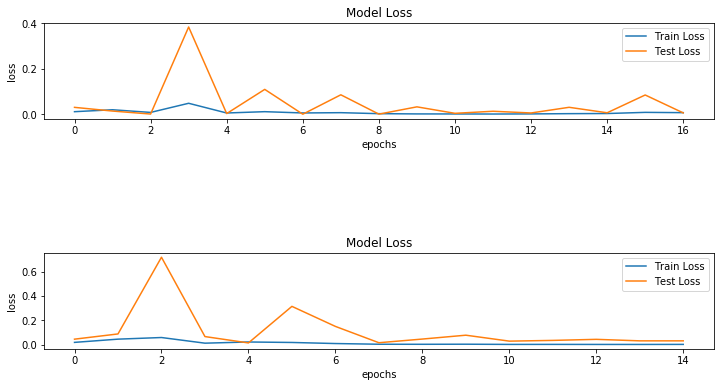

In [10]:
# Plot the model loss
fig = plt.figure(figsize=(12,6))

fig.add_subplot(311)
plt.plot(historyA.history['loss'], label='Train Loss')
plt.plot(historyA.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

fig.add_subplot(313)
plt.plot(historyB.history['loss'], label='Train Loss')
plt.plot(historyB.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

plt.show();

Text(0.5, 0.98, 'Indonesia')

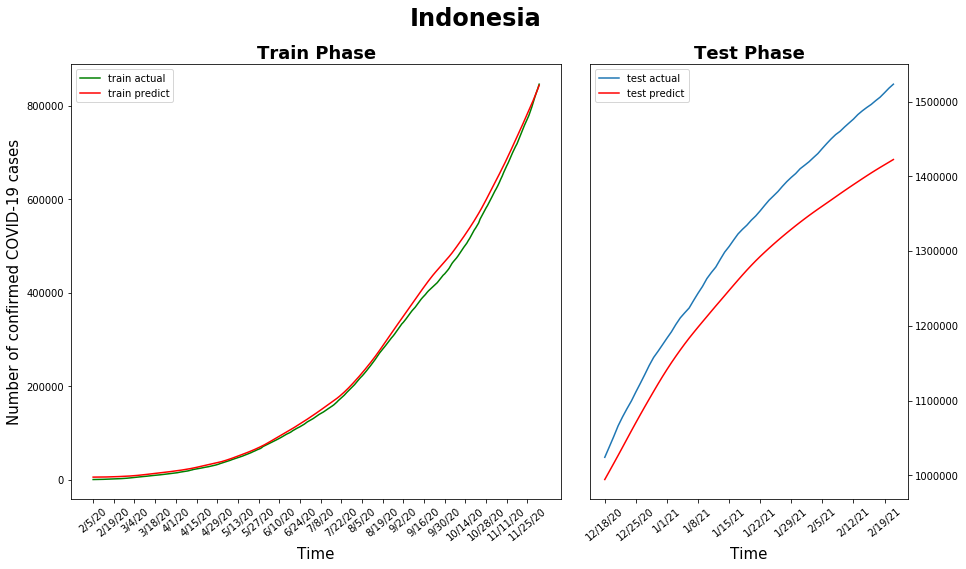

In [11]:
lb = look_back

# FIRST for ALL TIME
# divide the x axis values for Train and Test phases
x1 = x[lb:lb + len(y_trainA)]
x2 = x[2 * lb + len(y_trainA): 2 * lb + len(y_trainA) + len(y_testA)]

# plot the graph
fig = plt.figure(figsize=(15,8))
# make two subplots
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=3)
ax2 = plt.subplot2grid((1, 5), (0, 3), colspan=2)

# First subplot for TRAIN SET
ax1.plot(x1, y_trainA, 'g', label="train actual")
ax1.plot(x1, trainA_predict[:,0], 'r', label="train predict")
# title and axis titles
ax1.set_title("Train Phase", fontsize=18, fontweight='bold')
ax1.set_xlabel('Time', fontsize=15)
ax1.set_ylabel('Number of confirmed COVID-19 cases', fontsize=15)
# xticks and legends
ind = [i for i in range(0, len(x1), 14)]
date = [x1[i] for i in ind]
ax1.set_xticks(ind)
ax1.set_xticklabels(date, rotation=40)
ax1.legend()

# Second subplot for TEST SET
ax2.plot(x2, y_testA[:len(y_testA)], label="test actual")
ax2.plot(x2, testA_predict[:,0][:len(y_testA)], 'r', label="test predict")
# title and axis titles
ax2.set_title("Test Phase", fontsize=18, fontweight='bold')
ax2.set_xlabel('Time', fontsize=15)
ax2.yaxis.tick_right()
# xticks and legends
ind = [i for i in range(0, len(x2), 7)]
date = [x2[i] for i in ind]
ax2.set_xticks(ind)
ax2.set_xticklabels(date, rotation=40)
ax2.legend()

fig.suptitle(country, fontsize=24, fontweight='bold')

Text(0.5, 0.98, 'Indonesia')

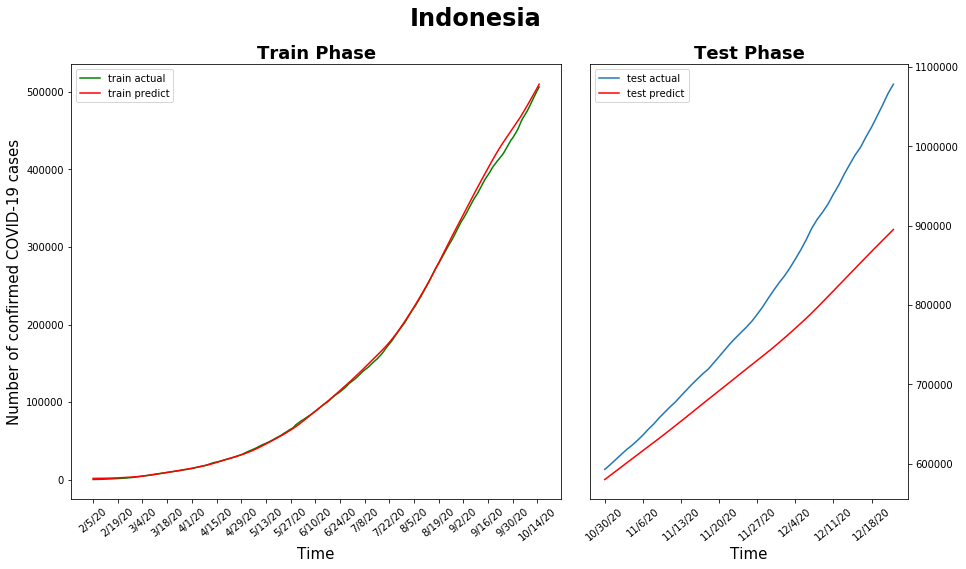

In [12]:
# SECOND for for the data before VACCINATION PROGRAM
# divide the x axis values for Train and Test phases
x1 = x[lb:lb + len(y_trainB)]
x2 = x[2 * lb + len(y_trainB): 2 * lb + len(y_trainB) + len(y_testB)]

# plot the graph
fig = plt.figure(figsize=(15,8))
# make two subplots
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=3)
ax2 = plt.subplot2grid((1, 5), (0, 3), colspan=2)

# First subplot for TRAIN SET
ax1.plot(x1, y_trainB, 'g', label="train actual")
ax1.plot(x1, trainB_predict[:,0], 'r', label="train predict")
# title and axis titles
ax1.set_title("Train Phase", fontsize=18, fontweight='bold')
ax1.set_xlabel('Time', fontsize=15)
ax1.set_ylabel('Number of confirmed COVID-19 cases', fontsize=15)
# xticks and legends
ind = [i for i in range(0, len(x1), 14)]
date = [x1[i] for i in ind]
ax1.set_xticks(ind)
ax1.set_xticklabels(date, rotation=40)
ax1.legend()

# Second subplot for TEST SET
ax2.plot(x2, y_testB[:len(y_testB)], label="test actual")
ax2.plot(x2, testB_predict[:,0][:len(y_testB)], 'r', label="test predict")
# title and axis titles
ax2.set_title("Test Phase", fontsize=18, fontweight='bold')
ax2.set_xlabel('Time', fontsize=15)
ax2.yaxis.tick_right()
# xticks and legends
ind = [i for i in range(0, len(x2), 7)]
date = [x2[i] for i in ind]
ax2.set_xticks(ind)
ax2.set_xticklabels(date, rotation=40)
ax2.legend()

fig.suptitle(country, fontsize=24, fontweight='bold')

In [13]:
# FOR ALL TIME
print('---ALL TIME---')
print("Future Prediction: " + str(testA_predict[-1]))
tPctA = (testA_predict[-1] - procDataA[-1]) / procDataA[-1]
print("Trend Percentage: " + str(tPctA * 100))

---ALL TIME---
Future Prediction: [1422452.55748427]
Trend Percentage: [-6.61290909]


In [14]:
# to test future prediction on the same date of All Time data, we use the built model from Before Vaccination data
# with the test set from All Time data
testB_predictFuture = modelB.predict(x_testA)

# invert the prediction results
testB_predictFuture = testB_predictFuture * (trainA_max - trainA_min) + trainA_min

In [15]:
# BEFORE VACCINATION PROGRAM STARTED
print('---BEFORE VACCINATION PROGRAM STARTED')
print("Future Prediction: " + str(testB_predictFuture[-1]))
tPctB = (testB_predictFuture[-1] - procDataA[-1]) / procDataA[-1]
print("Trend Percentage: " + str(tPctB * 100))

---BEFORE VACCINATION PROGRAM STARTED
Future Prediction: [1394214.12954879]
Trend Percentage: [-8.46682304]
